## 1.0 Data Exploration

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

pd.set_option("display.max_columns", 200)
DATA_DIR = Path(".")

In [ ]:
train = pd.read_csv(DATA_DIR / "train.csv", parse_dates=["date"])
test  = pd.read_csv(DATA_DIR / "test.csv",  parse_dates=["date"])
stores = pd.read_csv(DATA_DIR / "stores.csv")
transactions = pd.read_csv(DATA_DIR / "transactions.csv", parse_dates=["date"])
oil = pd.read_csv(DATA_DIR / "oil.csv", parse_dates=["date"])
holidays = pd.read_csv(DATA_DIR / "holidays_events.csv", parse_dates=["date"])

for df in [train, test, stores, transactions]:
    if "store_nbr" in df.columns:
        df["store_nbr"] = df["store_nbr"].astype("int32")
if "cluster" in stores.columns:
    stores["cluster"] = stores["cluster"].astype("int16")

print("Loaded shapes:",
      "\n  train:", train.shape,
      "\n  test:", test.shape,
      "\n  stores:", stores.shape,
      "\n  transactions:", transactions.shape,
      "\n  oil:", oil.shape,
      "\n  holidays:", holidays.shape)


Loaded shapes: 
  train: (3000888, 6) 
  test: (28512, 5) 
  stores: (54, 5) 
  transactions: (83488, 3) 
  oil: (1218, 2) 
  holidays: (350, 6)


In [ ]:
print("TRAIN head (target = 'sales'):")
display(train.head(10)[["date","store_nbr","family","sales","onpromotion"]])

print("\nTEST head (no target):")
display(test.head(10)[["date","store_nbr","family","onpromotion"]])


TRAIN head (target = 'sales'):


,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,2013-01-01,1,CELEBRATION,0.0,0
7,2013-01-01,1,CLEANING,0.0,0
8,2013-01-01,1,DAIRY,0.0,0
9,2013-01-01,1,DELI,0.0,0



TEST head (no target):


,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0
5,2017-08-16,1,BREAD/BAKERY,12
6,2017-08-16,1,CELEBRATION,0
7,2017-08-16,1,CLEANING,25
8,2017-08-16,1,DAIRY,45
9,2017-08-16,1,DELI,18


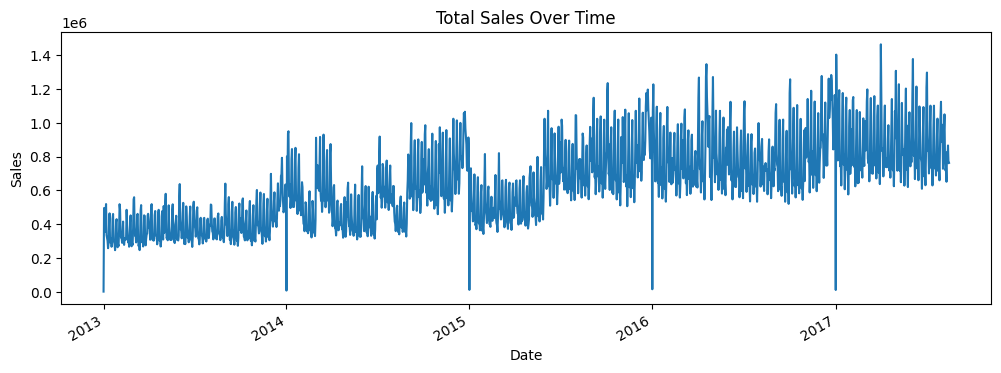

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
daily_sales = train.groupby("date")["sales"].sum()
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()


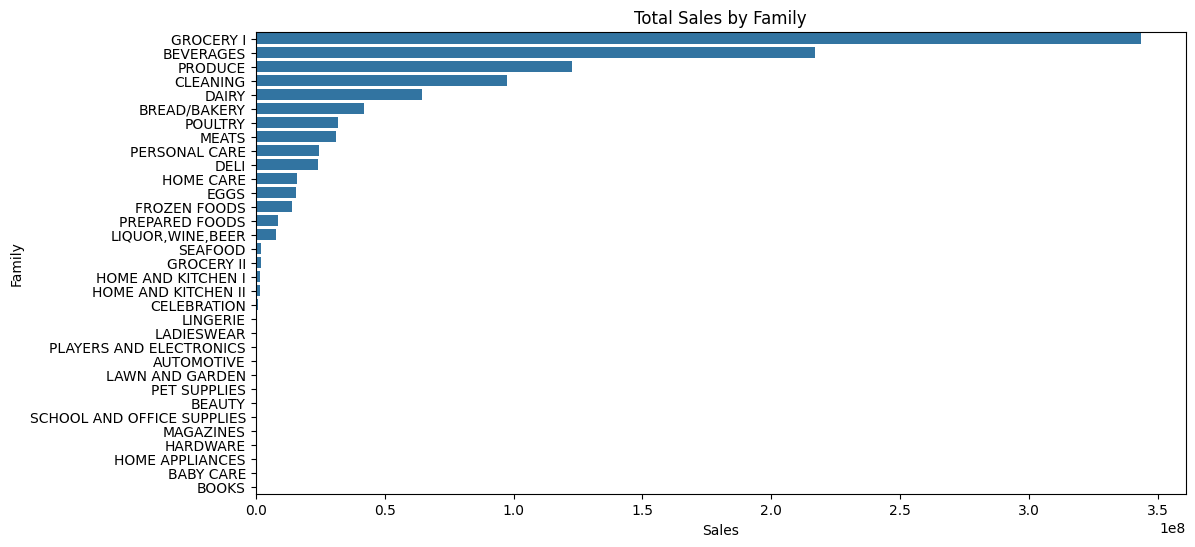

In [48]:
plt.figure(figsize=(12,6))
family_sales = train.groupby("family")["sales"].sum().sort_values(ascending=False)
sns.barplot(x=family_sales.values, y=family_sales.index)
plt.title("Total Sales by Family")
plt.xlabel("Sales")
plt.ylabel("Family")
plt.show()

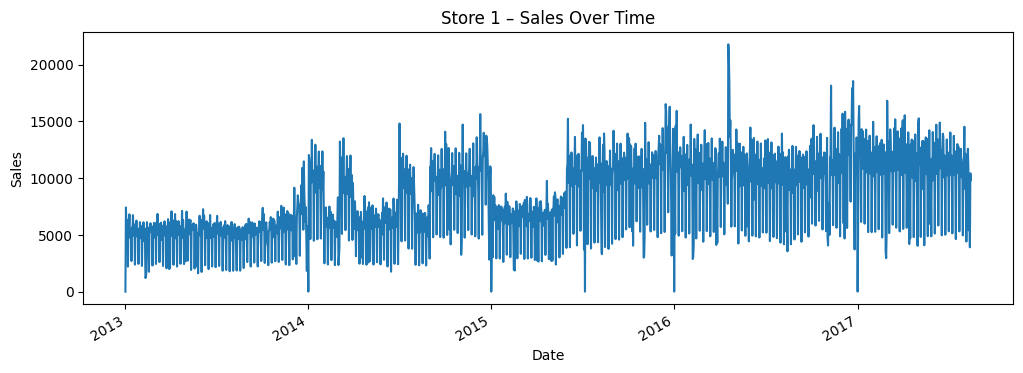

In [49]:
plt.figure(figsize=(12,4))
store1_sales = train[train["store_nbr"]==1].groupby("date")["sales"].sum()
store1_sales.plot()
plt.title("Store 1 – Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

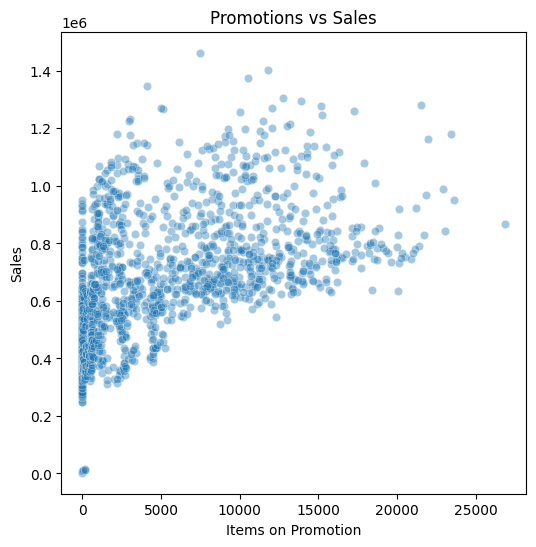

In [50]:
plt.figure(figsize=(6,6))
agg = train.groupby("date")[["sales","onpromotion"]].sum()
sns.scatterplot(data=agg, x="onpromotion", y="sales", alpha=0.4)
plt.title("Promotions vs Sales")
plt.xlabel("Items on Promotion")
plt.ylabel("Sales")
plt.show()

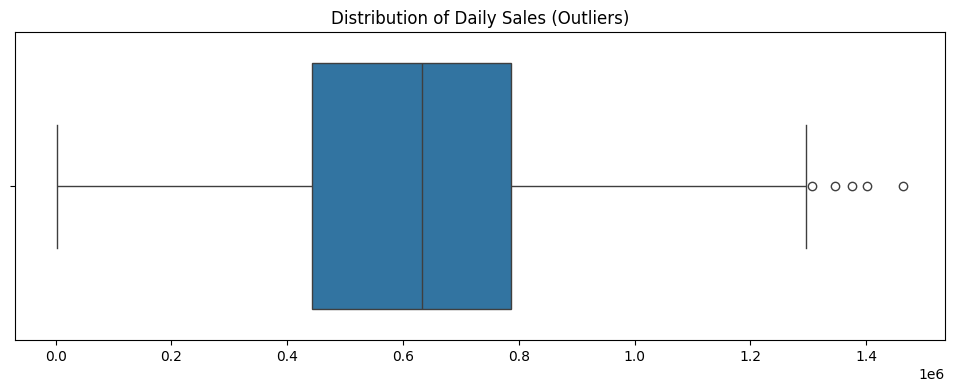

In [ ]:
plt.figure(figsize=(12,4))
daily = train.groupby("date")["sales"].sum()
sns.boxplot(x=daily.values)
plt.title("Distribution of Daily Sales (Outliers)")
plt.show()

## 1.1 Data Quality & Preprocessing

In [9]:
print(train.info())
print("\nMissing values:\n", train.isna().sum())

print("\nNumeric summary:\n", train[["sales","onpromotion"]].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int32         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 125.9+ MB
None

Missing values:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Numeric summary:
               sales   onpromotion
count  3.000888e+06  3.000888e+06
mean   3.577757e+02  2.602770e+00
std    1.101998e+03  1.221888e+01
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    1.100000e+01  0.000000e+00
75%    1.958473e+02  0.000000e+00
max    1.247170e+05  7.410000e+02


In [ ]:
# 1. Ensure no negative sales (clip at 0 if they exist)
train["sales"] = train["sales"].clip(lower=0)

# 2. Ensure onpromotion is integer
train["onpromotion"] = train["onpromotion"].fillna(0).astype(int)

# 3. Date should be datetime
train["date"] = pd.to_datetime(train["date"])


In [11]:
def iqr_filter(df, col="sales"):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Example: apply per family
filtered_train = train.groupby("family", group_keys=False).apply(iqr_filter, col="sales")

print("Original shape:", train.shape)
print("Filtered shape:", filtered_train.shape)

Original shape: (3000888, 6)
Filtered shape: (2800614, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20832\2378622553.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_train = train.groupby("family", group_keys=False).apply(iqr_filter, col="sales")


In [12]:
# Normalize numeric features if using neural nets

#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#train[["sales_norm","onpromotion_norm"]] = scaler.fit_transform(train[["sales","onpromotion"]])


## 2.0 Baseline - Linear Regression

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df0 = filtered_train.sort_values("date").copy()

df0["time_idx"] = (df0["date"] - df0["date"].min()).dt.days
df0["dow"]      = df0["date"].dt.dayofweek
df0["month"]    = df0["date"].dt.month

df0 = pd.get_dummies(df0, columns=["family","store_nbr"], drop_first=True)

dates = df0["date"].copy()
X = df0.drop(columns=["date","sales"])
y = df0["sales"]

In [27]:
df0.head()

,id,date,sales,onpromotion,time_idx,dow,month,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
0,0,2013-01-01,0.0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1775,1775,2013-01-01,0.0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1751,1751,2013-01-01,0.0,0,0,1,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1718,1718,2013-01-01,0.0,0,0,1,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1685,1685,2013-01-01,0.0,0,0,1,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [ ]:
dates = df0["date"].copy()
X = df0.drop(columns=["date","sales"])
y = df0["sales"]

# Time-based split:
unique_dates = np.sort(dates.unique())
cutoff = unique_dates[int(0.8 * len(unique_dates))]

train_mask = dates <= cutoff
val_mask   = dates >  cutoff

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val,   y_val   = X.loc[val_mask],   y.loc[val_mask]

print("Train:", X_train.shape, "Val:", X_val.shape)
print("Date range -> train max:", dates.loc[train_mask].max(), "| val min:", dates.loc[val_mask].min())

Train: (2269119, 90) Val: (531495, 90)
Date range -> train max: 2016-09-12 00:00:00 | val min: 2016-09-13 00:00:00


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

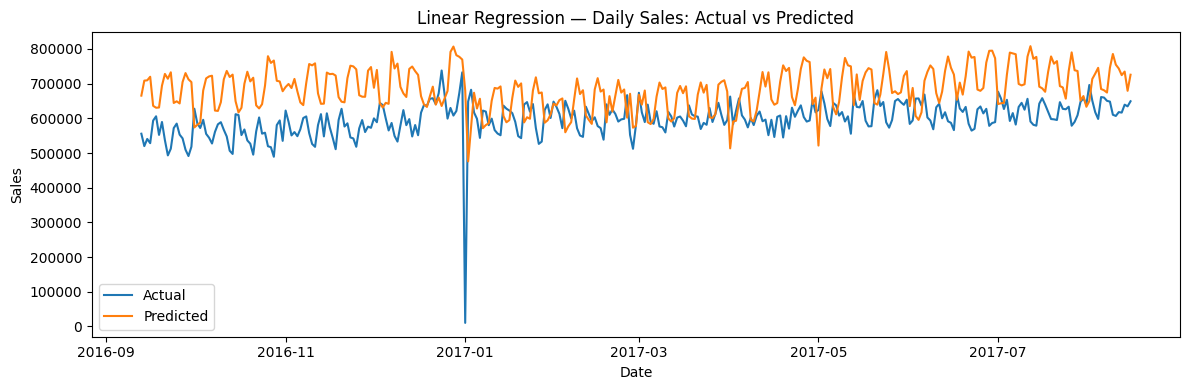

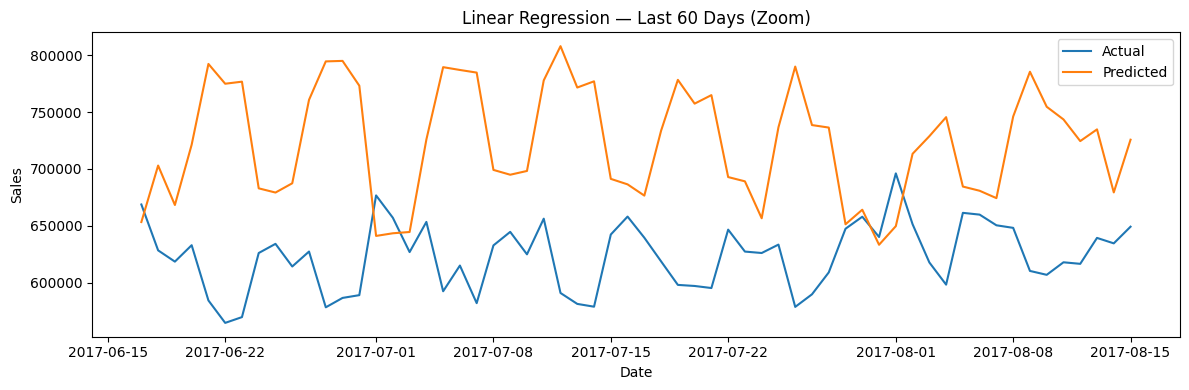

In [ ]:
pred_df = pd.DataFrame({
    "date":   dates.loc[val_mask].values,
    "actual": y_val.values,
    "pred":   np.ravel(y_pred)
}).sort_values("date").reset_index(drop=True)

# Aggregate across series to daily totals
daily = pred_df.groupby("date", as_index=False).sum(numeric_only=True)

# Full validation window
plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["actual"], label="Actual")
plt.plot(daily["date"], daily["pred"],   label="Predicted")
plt.title("Linear Regression — Daily Sales: Actual vs Predicted")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()

# Last 60 days zoom
last_n = 60
plt.figure(figsize=(12,4))
plt.plot(daily["date"].iloc[-last_n:], daily["actual"].iloc[-last_n:], label="Actual")
plt.plot(daily["date"].iloc[-last_n:], daily["pred"].iloc[-last_n:],   label="Predicted")
plt.title(f"Linear Regression — Last {last_n} Days (Zoom)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()


In [31]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

# to avoid log(0) errors:
eps = 1e-9
y_pred_clipped = np.maximum(y_pred, eps)
y_val_clipped  = np.maximum(y_val, eps)

rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, y_pred_clipped))

print(f"Baseline Linear Regression RMSLE: {rmsle:.4f}")

Baseline Linear Regression RMSLE: 2.3631


## 2.1 Baseline - XGB - Extreme Gradient Boosting

In [32]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

model.fit(X_train, y_train, verbose=False)
y_pred = model.predict(X_val)


In [33]:
y_pred_clipped = np.maximum(y_pred, eps)
y_val_clipped  = np.maximum(y_val, eps)

rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, y_pred_clipped))
print(f"XGBoost RMSLE: {rmsle:.4f}")

XGBoost RMSLE: 1.4887


## 3.0 Feature Engineering - Improved XGB (LAG VARIABLES)

In [34]:
df = filtered_train.copy()

df = df.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)
df["onpromotion"] = df["onpromotion"].fillna(0).astype(int)

df["time_idx"] = (df["date"] - df["date"].min()).dt.days
df["dow"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

# Per-series lags/rollings
grp = ["store_nbr", "family"]

# Sales lags
for lag in [1, 7, 14, 28]:
    df[f"sales_lag_{lag}"] = df.groupby(grp)["sales"].shift(lag)

# Promo lags
for lag in [1, 7, 14]:
    df[f"onpromo_lag_{lag}"] = df.groupby(grp)["onpromotion"].shift(lag)

# Rolling means
df["sales_roll_7"]  = df.groupby(grp)["sales"].shift(1).rolling(7).mean()
df["sales_roll_28"] = df.groupby(grp)["sales"].shift(1).rolling(28).mean()

# Keep rows with complete feature info
feature_cols = [
    "time_idx", "dow", "month", "onpromotion",
    "sales_lag_1", "sales_lag_7", "sales_lag_14", "sales_lag_28",
    "onpromo_lag_1", "onpromo_lag_7", "onpromo_lag_14",
    "sales_roll_7", "sales_roll_28",
    "store_nbr", "family",
]
df = df.dropna(subset=feature_cols + ["sales"]).reset_index(drop=True)

# One-hot for XGBoost
df = pd.get_dummies(df, columns=["store_nbr", "family"], drop_first=True)


In [35]:
df.head()

,id,date,sales,onpromotion,time_idx,dow,month,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,onpromo_lag_1,onpromo_lag_7,onpromo_lag_14,sales_roll_7,sales_roll_28,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,49896,2013-01-29,2.0,0,28,1,1,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.571429,2.142857,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,51678,2013-01-30,6.0,0,29,2,1,2.0,3.0,1.0,2.0,0.0,0.0,0.0,2.714286,2.214286,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,53460,2013-01-31,0.0,0,30,3,1,6.0,0.0,1.0,3.0,0.0,0.0,0.0,3.142857,2.357143,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,55242,2013-02-01,3.0,0,31,4,2,0.0,5.0,0.0,3.0,0.0,0.0,0.0,3.142857,2.250000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,57024,2013-02-02,0.0,0,32,5,2,3.0,4.0,5.0,5.0,0.0,0.0,0.0,2.857143,2.250000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [36]:
X = df.drop(columns=["date", "sales"])
y = df["sales"]

# Time-based split
unique_dates = np.sort(df["date"].unique())
cutoff = unique_dates[int(0.8 * len(unique_dates))]
train_mask = df["date"] <= cutoff
val_mask   = df["date"] >  cutoff

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val,   y_val   = X.loc[val_mask],   y.loc[val_mask]

print("Train:", X_train.shape, "Val:", X_val.shape)
print("Date range -> train max:", df.loc[train_mask, "date"].max(), "| val min:", df.loc[val_mask, "date"].min())

Train: (2227522, 99) Val: (523207, 99)
Date range -> train max: 2016-09-17 00:00:00 | val min: 2016-09-18 00:00:00


In [37]:
# Log-transform target for better RMSLE behavior
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

dtrain = xgb.DMatrix(X_train, label=y_train_log)
dval   = xgb.DMatrix(X_val,   label=y_val_log)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",        # we'll compute RMSLE separately
    "eta": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
    "tree_method": "hist",        # fast & memory-friendly
}

evals = [(dtrain, "train"), (dval, "val")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=3000,
    evals=evals,
    early_stopping_rounds=200,
    verbose_eval=100
)

# Predict on validation and invert the log
y_pred_log = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))
y_pred     = np.expm1(y_pred_log)

[0]	train-rmse:2.53932	val-rmse:2.53546
[100]	train-rmse:0.38910	val-rmse:0.46009
[200]	train-rmse:0.36990	val-rmse:0.46217
[300]	train-rmse:0.36263	val-rmse:0.46382
[322]	train-rmse:0.36139	val-rmse:0.46472


In [38]:
# Cell 6c: RMSLE evaluation (original scale)

from sklearn.metrics import mean_squared_log_error

eps = 1e-9
y_pred_clip = np.maximum(y_pred, eps)
y_val_clip  = np.maximum(y_val.values, eps)

rmsle = np.sqrt(mean_squared_log_error(y_val_clip, y_pred_clip))
print(f"XGBoost (lags + log target + time split) RMSLE: {rmsle:.4f}")


XGBoost (lags + log target + time split) RMSLE: 0.4592


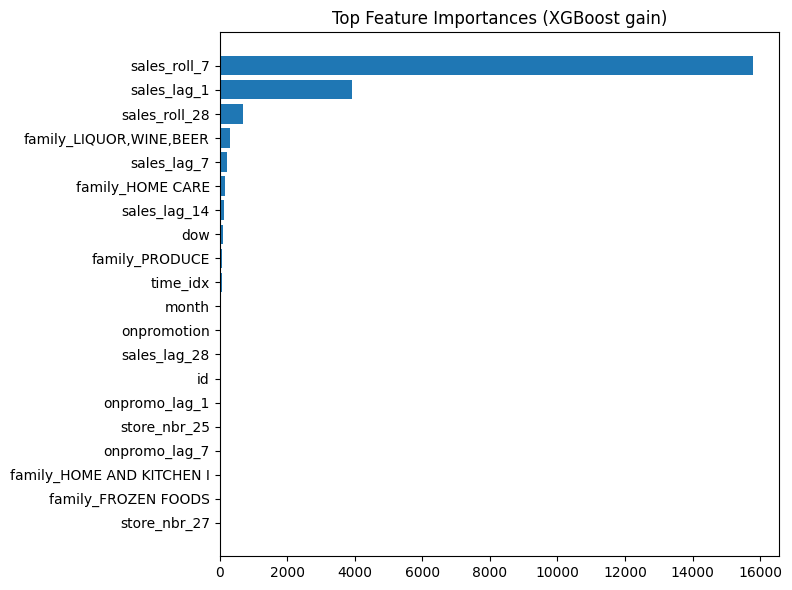

In [ ]:
importance = xgb_model.get_score(importance_type="gain")
# Align with columns created; XGB uses feature names as column names
feat_names = list(X_train.columns)
# Map importance into an array aligned with feat_names
scores = np.array([importance.get(f, 0.0) for f in feat_names])

order = np.argsort(scores)[::-1][:20]
plt.figure(figsize=(8,6))
plt.barh(np.array(feat_names)[order][::-1], scores[order][::-1])
plt.title("Top Feature Importances (XGBoost gain)")
plt.tight_layout()
plt.show()


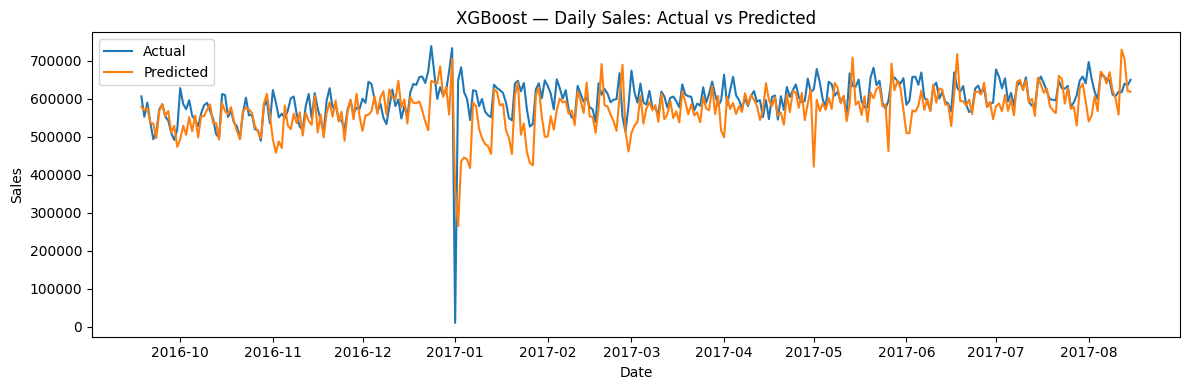

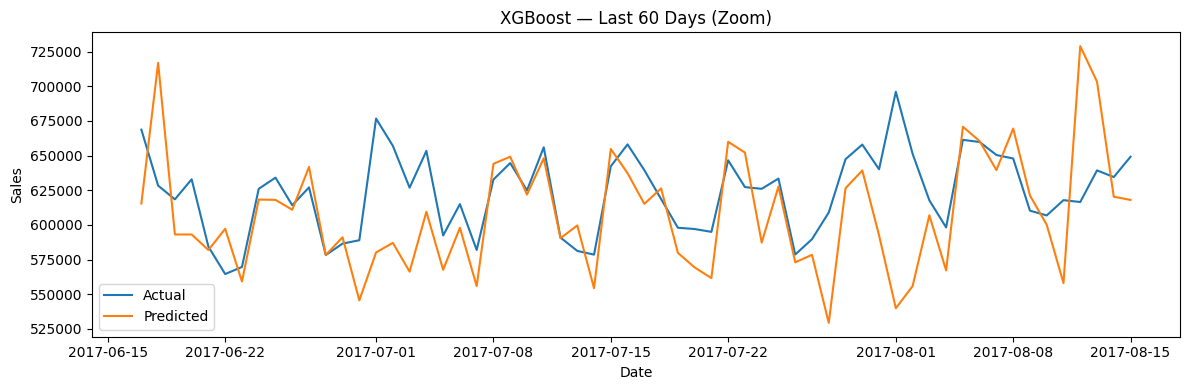

In [40]:
pred_df = pd.DataFrame({
    "date": df.loc[val_mask, "date"].values,
    "actual": y_val.values,
    "pred": y_pred
}).sort_values("date").reset_index(drop=True)

daily = pred_df.groupby("date", as_index=False).sum()

plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["actual"], label="Actual")
plt.plot(daily["date"], daily["pred"],   label="Predicted")
plt.title("XGBoost — Daily Sales: Actual vs Predicted")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()

# Last 60 days zoom
last_n = 60
plt.figure(figsize=(12,4))
plt.plot(daily["date"].iloc[-last_n:], daily["actual"].iloc[-last_n:], label="Actual")
plt.plot(daily["date"].iloc[-last_n:], daily["pred"].iloc[-last_n:],   label="Predicted")
plt.title("XGBoost — Last 60 Days (Zoom)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()


## 3.1 Baseline - LightGBM - Light Gradient Boosting Machine

In [ ]:
df = train.copy()  # or filtered_train.copy() if you prefer
df = df.sort_values(["store_nbr","family","date"]).reset_index(drop=True)

# time features
df["time_idx"] = (df["date"] - df["date"].min()).dt.days
df["dow"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

# ensure types
df["store_nbr"] = df["store_nbr"].astype("category")
df["family"] = df["family"].astype("category")

# per-series lags
grp_keys = ["store_nbr","family"]
for lag in [1, 7, 14, 28]:
    df[f"sales_lag_{lag}"] = df.groupby(grp_keys)["sales"].shift(lag)
    df[f"onpromo_lag_{lag}"] = df.groupby(grp_keys)["onpromotion"].shift(lag)

# per-series rolling means on sales
df["sales_roll_7"]  = df.groupby(grp_keys)["sales"].shift(1).rolling(7).mean()
df["sales_roll_28"] = df.groupby(grp_keys)["sales"].shift(1).rolling(28).mean()

# drop rows with NaNs introduced by lags/rollings (keeps training clean)
feature_cols = [
    "time_idx","dow","month","onpromotion",
    "sales_lag_1","sales_lag_7","sales_lag_14","sales_lag_28",
    "onpromo_lag_1","onpromo_lag_7","onpromo_lag_14","onpromo_lag_28",
    "sales_roll_7","sales_roll_28","store_nbr","family"
]
df = df.dropna(subset=feature_cols + ["sales"]).reset_index(drop=True)

print("Prepared shape:", df.shape)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20832\1174179844.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"sales_lag_{lag}"] = df.groupby(grp_keys)["sales"].shift(lag)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20832\1174179844.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"onpromo_lag_{lag}"] = df.groupby(grp_keys)["onpromotion"].shift(lag)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20832\1174179844.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

Prepared shape: (2950992, 19)


In [ ]:
last_n_days = 60  # adjust if you want a longer/shorter validation
max_date = df["date"].max()
cutoff_date = max_date - pd.Timedelta(days=last_n_days)

train_mask = df["date"] <= cutoff_date
val_mask   = df["date"] >  cutoff_date

X_train = df.loc[train_mask, feature_cols].copy()
y_train = df.loc[train_mask, "sales"].copy()
X_val   = df.loc[val_mask,   feature_cols].copy()
y_val   = df.loc[val_mask,   "sales"].copy()

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (2844072, 16) Val: (106920, 16)


In [ ]:
import lightgbm as lgb
import numpy as np

y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

# categorical features (pass their names)
categorical_feats = [c for c in ["store_nbr","family"] if c in X_train.columns]

model = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=128,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train_log,
    eval_set=[(X_val, y_val_log)],
    eval_metric="rmse",
    categorical_feature=categorical_feats or None,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=0),
    ],
)

# predict and invert log
y_pred_log = model.predict(X_val, num_iteration=model.best_iteration_)
y_pred = np.expm1(y_pred_log)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 2844072, number of used features: 16
[LightGBM] [Info] Start training from score 2.916455
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[713]	valid_0's rmse: 0.375454	valid_0's l2: 0.140966


In [ ]:
from sklearn.metrics import mean_squared_log_error

eps = 1e-9
y_pred_clip = np.maximum(y_pred, eps)
y_val_clip  = np.maximum(y_val.values, eps)

rmsle = np.sqrt(mean_squared_log_error(y_val_clip, y_pred_clip))
print(f"LightGBM (lags + log target) RMSLE: {rmsle:.4f}")


LightGBM (lags + log target) RMSLE: 0.3754


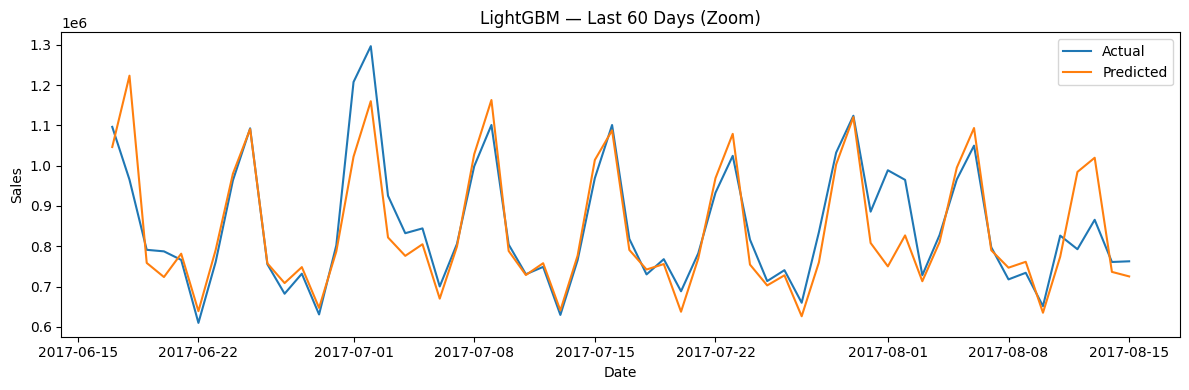

In [46]:
pred_df = pd.DataFrame({
    "date": df.loc[val_mask, "date"].values,
    "actual": y_val.values,
    "pred": y_pred
}).sort_values("date").reset_index(drop=True)

daily = pred_df.groupby("date", as_index=False).sum()

# Last 60 days zoom
last_n = 60
plt.figure(figsize=(12,4))
plt.plot(daily["date"].iloc[-last_n:], daily["actual"].iloc[-last_n:], label="Actual")
plt.plot(daily["date"].iloc[-last_n:], daily["pred"].iloc[-last_n:],   label="Predicted")
plt.title("LightGBM — Last 60 Days (Zoom)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()

## 3.0 Baseline - LSTM - Long Short Term Memory Neural Network

## 4.0 SOTA Models - Transformers, Chronos-Bolt, TSMixer, TimesFM